# Analisis espacial

## Autor: Pedro Jose Leal

### Descripción de la Base de Datos: US-Accidents

Este es un conjunto de datos de accidentes automovilísticos a nivel nacional que abarca 49 estados de los EE. UU.. Los datos de los accidentes se recopilaron desde febrero de 2016 hasta diciembre de 2021, utilizando múltiples API que proporcionan datos de incidentes de tráfico en tiempo real.

Estas API transmiten datos de tráfico capturados por diversas entidades, como los departamentos de transporte estatales y de EE. UU., agencias de aplicación de la ley, cámaras de tráfico y sensores de tráfico dentro de las redes de carreteras. Actualmente, hay alrededor de 2.8 millones de registros de accidentes en este conjunto de datos.

Para el análisis de datos que se va a comenzar, solo se utilizarán las siguientes variables del conjunto de datos:

*   `ID`
*   `Start_Time`
*   `Start_Lat`
*   `Start_Lng`
*   `Temperature(F)`
*   `Humidity(%)`
*   `Pressure(in)`

Cargando y filtrando el dataset...
Dataset cargado con 6985228 registros iniciales.

--- Limpieza Avanzada de Datos ---
Se eliminaron 164846 registros con valores nulos o cero.
El dataset final tiene 6820382 registros válidos.

--- Análisis de Estaciones ---
Hay 2753388 estaciones únicas en el dataset.

--- Análisis de Reportes por Hora ---
Generando diagrama de barras de reportes por hora...


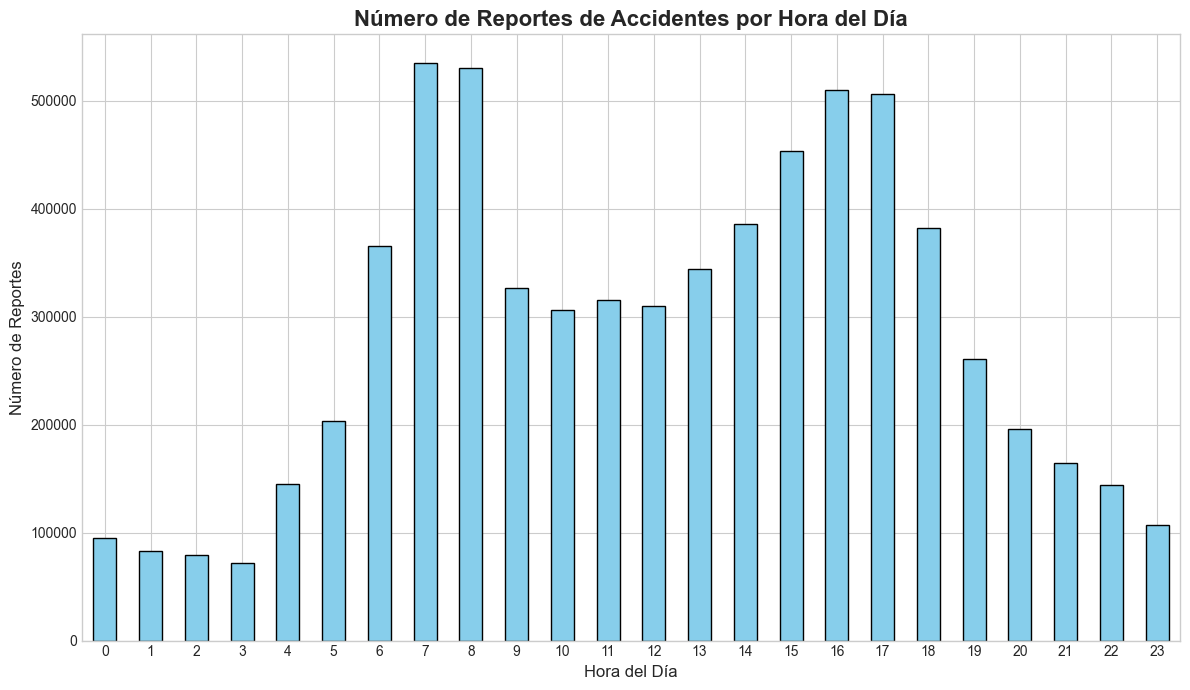


--- Generando Mapas de Calor ---


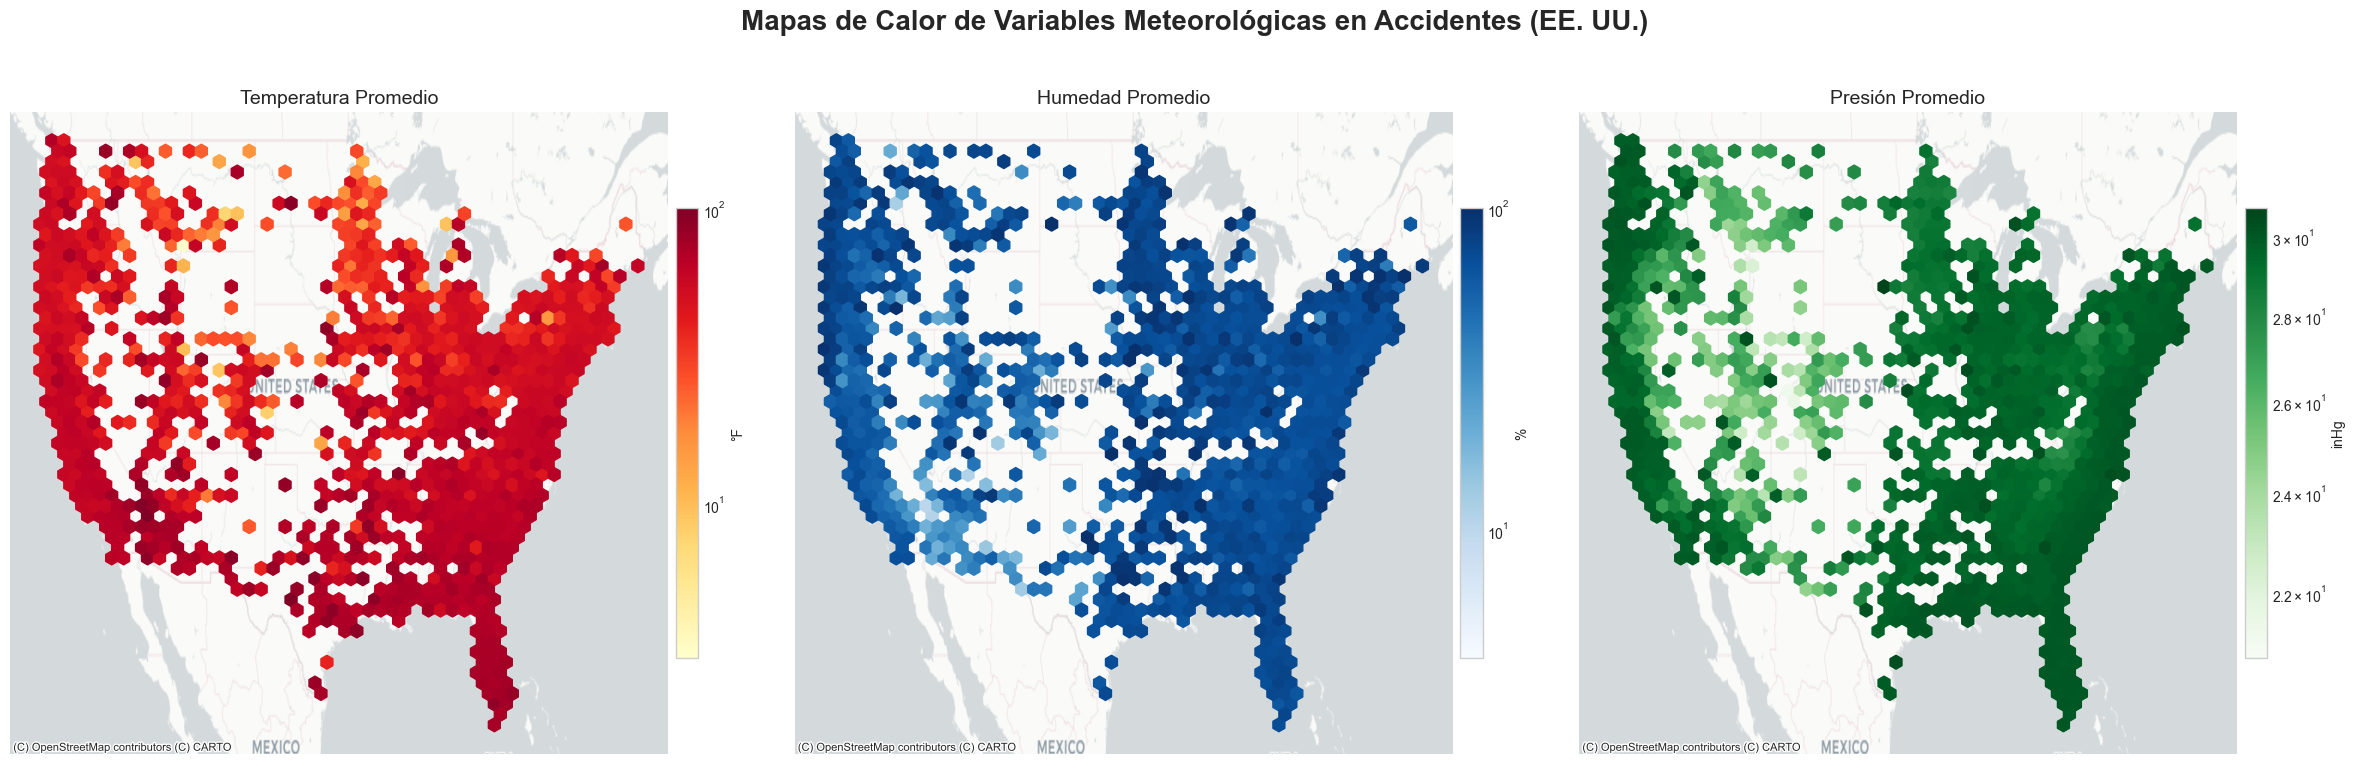

In [3]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# --- PASO 2: DEFINICIÓN DE FUNCIONES ---

def cargar_y_preparar_datos(path, columnas):
    """
    Carga el dataset desde un archivo CSV, filtra por columnas y realiza una limpieza inicial.
    
    Args:
        path (str): Ruta al archivo CSV.
        columnas (list): Lista de columnas a cargar.
        
    Returns:
        pandas.DataFrame: DataFrame limpio y preparado.
    """
    print("Cargando y filtrando el dataset...")
    df = pd.read_csv(path, usecols=columnas)
    
    # Conversión de tiempo y eliminación de nulos en columnas clave
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df.dropna(subset=['Start_Time', 'Start_Lat', 'Start_Lng'], inplace=True)
    print(f"Dataset cargado con {len(df)} registros iniciales.")
    return df

def limpiar_datos_invalidos(df, columnas_a_validar):
    """
    Elimina registros que contienen valores nulos o cero en columnas específicas.
    
    Args:
        df (pandas.DataFrame): DataFrame de entrada.
        columnas_a_validar (list): Columnas para verificar nulos y ceros.
        
    Returns:
        pandas.DataFrame: DataFrame sin los registros inválidos.
    """
    print("\n--- Limpieza Avanzada de Datos ---")
    registros_antes = len(df)
    
    # Eliminar nulos
    df.dropna(subset=columnas_a_validar, inplace=True)
    
    # Eliminar ceros en las columnas especificadas
    for col in columnas_a_validar:
        # Usamos df[col].ne(0) que es equivalente a (df[col] != 0) y es eficiente
        df = df[df[col].ne(0)]
        
    registros_despues = len(df)
    print(f"Se eliminaron {registros_antes - registros_despues} registros con valores nulos o cero.")
    print(f"El dataset final tiene {registros_despues} registros válidos.")
    return df

def analizar_estaciones(df):
    """
    Crea una columna 'estacion' y cuenta el número de estaciones únicas.
    
    Args:
        df (pandas.DataFrame): DataFrame con datos de latitud y longitud.
        
    Returns:
        pandas.DataFrame: DataFrame con la nueva columna 'estacion'.
    """
    print("\n--- Análisis de Estaciones ---")
    df['estacion'] = df['Start_Lat'].astype(str) + ',' + df['Start_Lng'].astype(str)
    numero_de_estaciones = df['estacion'].nunique()
    print(f"Hay {numero_de_estaciones} estaciones únicas en el dataset.")
    return df

def graficar_reportes_por_hora(df):
    """
    Genera y muestra un diagrama de barras del número de reportes por hora.
    
    Args:
        df (pandas.DataFrame): DataFrame con la columna 'Start_Time'.
    """
    print("\n--- Análisis de Reportes por Hora ---")
    df['Hour'] = df['Start_Time'].dt.hour
    reportes_por_hora = df['Hour'].value_counts().sort_index()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    reportes_por_hora.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

    ax.set_title('Número de Reportes de Accidentes por Hora del Día', fontsize=16, fontweight='bold')
    ax.set_xlabel('Hora del Día', fontsize=12)
    ax.set_ylabel('Número de Reportes', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    print("Generando diagrama de barras de reportes por hora...")
    plt.tight_layout()
    plt.show()

def graficar_mapas_de_calor(df, sample_size=50000):
    """
    Genera y muestra mapas de calor para Temperatura, Humedad y Presión.
    
    Args:
        df (pandas.DataFrame): DataFrame con datos geoespaciales y meteorológicos.
        sample_size (int): Número de muestras a usar para la visualización.
    """
    print("\n--- Generando Mapas de Calor ---")
    # Asegurarse de que el tamaño de la muestra no sea mayor que el dataframe
    if len(df) < sample_size:
        sample_size = len(df)
    
    df_sample = df.sample(n=sample_size, random_state=42)
    
    geometry = [Point(xy) for xy in zip(df_sample['Start_Lng'], df_sample['Start_Lat'])]
    gdf = gpd.GeoDataFrame(df_sample, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
    plt.suptitle('Mapas de Calor de Variables Meteorológicas en Accidentes (EE. UU.)', fontsize=20, fontweight='bold')

    variables = {
        'Temperatura': ('Temperature(F)', 'YlOrRd', '°F'),
        'Humedad': ('Humidity(%)', 'Blues', '%'),
        'Presión': ('Pressure(in)', 'Greens', 'inHg')
    }
    
    for i, (nombre, (col, cmap, label)) in enumerate(variables.items()):
        ax = axes[i]
        hb = ax.hexbin(gdf.geometry.x, gdf.geometry.y, C=gdf[col], reduce_C_function=np.mean, gridsize=50, cmap=cmap, bins='log')
        ax.set_title(f'{nombre} Promedio', fontsize=14)
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
        cb = fig.colorbar(hb, ax=ax, orientation='vertical', pad=0.01, shrink=0.7)
        cb.set_label(label)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- PASO 3: EJECUCIÓN PRINCIPAL DEL SCRIPT ---


    # --- CONFIGURACIÓN ---
path_al_archivo_csv = "./Datos/US_Accidents_March23.csv"
columnas_fundamentales = ['ID', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)']
columnas_a_validar = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)']

    # --- FLUJO DE TRABAJO ---
    # 1. Cargar datos
df = cargar_y_preparar_datos(path_al_archivo_csv, columnas_fundamentales)
    
    # 2. Limpiar valores nulos y ceros (¡NUEVO PASO!)
df_limpio = limpiar_datos_invalidos(df, columnas_a_validar)
    
    # 3. Analizar y contar estaciones
df_con_estaciones = analizar_estaciones(df_limpio)
    
    # 4. Graficar reportes por hora
graficar_reportes_por_hora(df_con_estaciones)
    
    # 5. Graficar mapas de calor
graficar_mapas_de_calor(df_con_estaciones)



Se ha creado un nuevo DataFrame 'df_7am' con 534767 registros.

--- DE AHORA EN ADELANTE, SE UTILIZARÁ ESTE DATAFRAME FILTRADO ---
Tomando una muestra de 534767 registros del DataFrame de las 7 AM...
Preparando la malla de interpolación para los datos de las 7 AM...
Generando los gráficos de superficie 3D para las 7 AM...


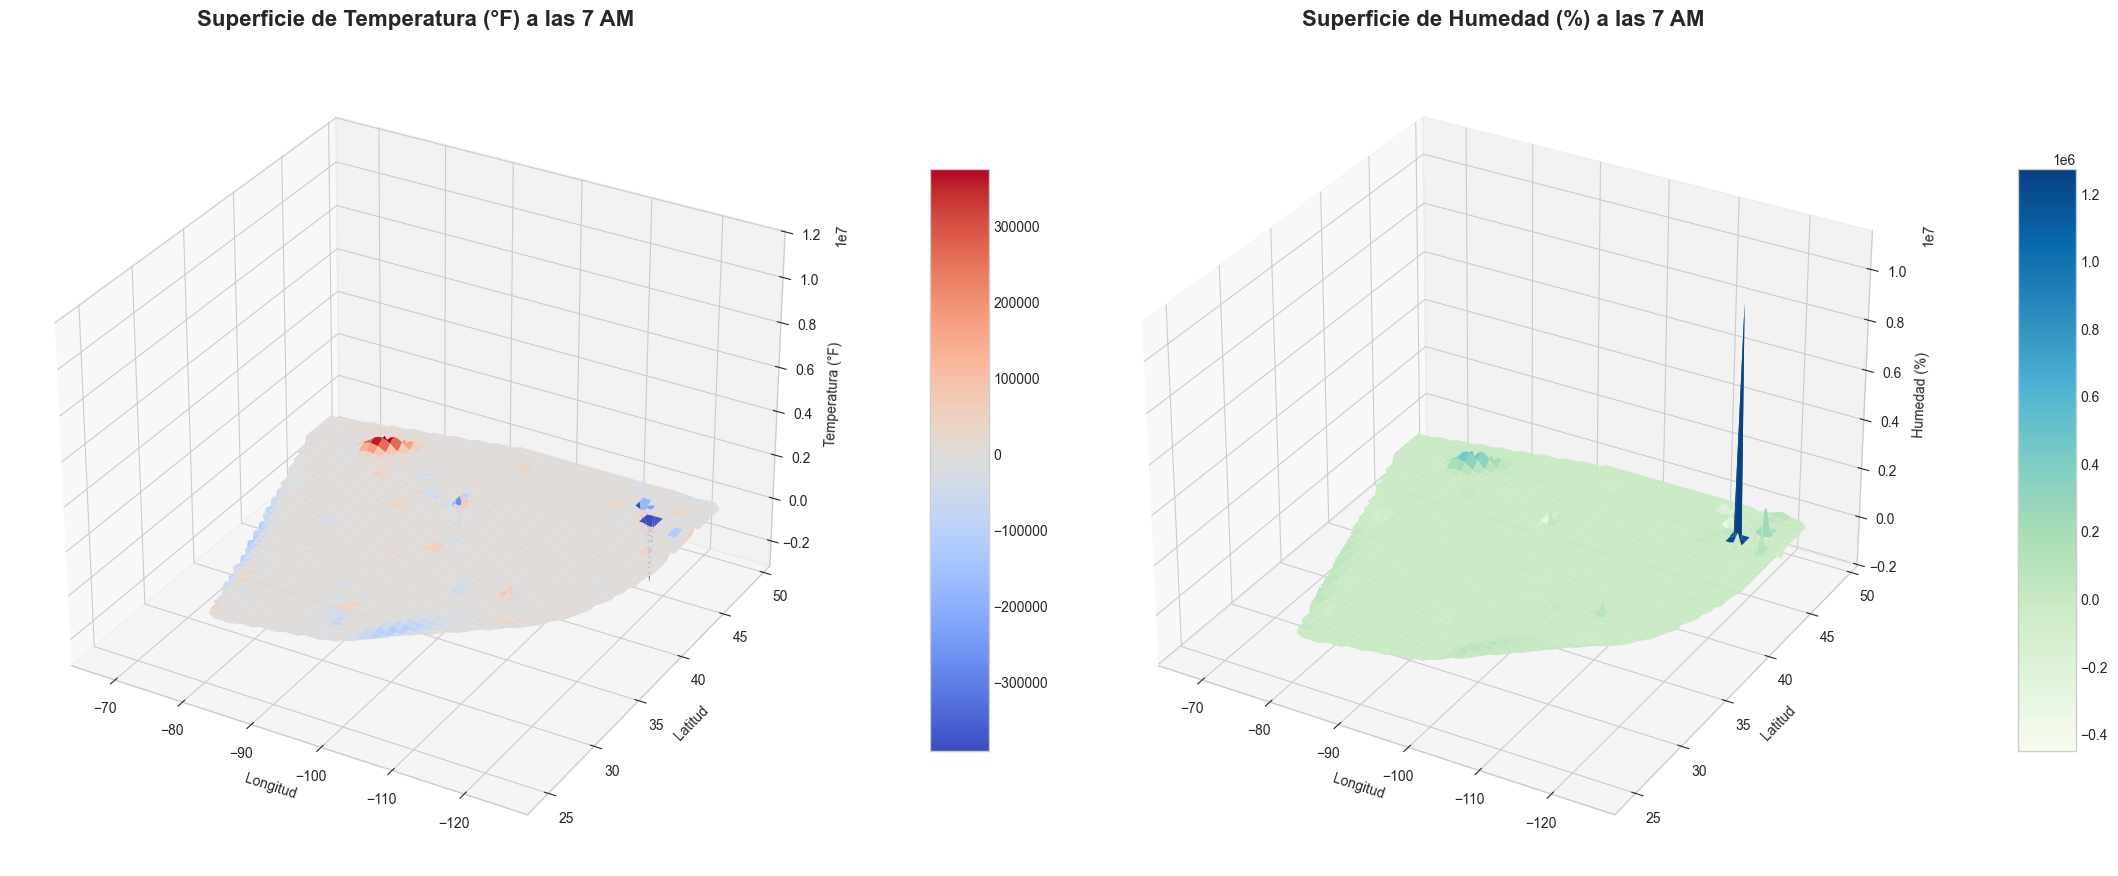

In [ ]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# --- PASO 2: FILTRADO DEL DATAFRAME PARA LAS 7 AM ---
# Se asume que 'df_con_estaciones' existe desde la ejecución de celdas anteriores.

hora_de_interes = 7
df_7am = df_con_estaciones[df_con_estaciones['Start_Time'].dt.hour == hora_de_interes].copy()

print(f"Se ha creado un nuevo DataFrame 'df_7am' con {len(df_7am)} registros.")
print("\n--- DE AHORA EN ADELANTE, SE UTILIZARÁ ESTE DATAFRAME FILTRADO ---")


# --- PASO 3: PREPARACIÓN DE DATOS PARA LA SUPERFICIE (SOLO DE LAS 7 AM) ---

# Dado que el DataFrame de las 7am es más pequeño, ajustamos el tamaño de la muestra.
# Si el df tiene menos de 5000 puntos, los usamos todos.
sample_size = len(df_7am) 

print(f"Tomando una muestra de {sample_size} registros del DataFrame de las 7 AM...")
df_sample_7am = df_7am.sample(n=sample_size, random_state=42)

# Extraemos las coordenadas (x, y) y los valores (z) del nuevo dataframe
x = df_sample_7am['Start_Lng'].values
y = df_sample_7am['Start_Lat'].values
z_temp = df_sample_7am['Temperature(F)'].values
z_hum = df_sample_7am['Humidity(%)'].values

print("Preparando la malla de interpolación para los datos de las 7 AM...")
# Creamos la malla sobre la cual se interpolará la superficie
grid_x, grid_y = np.mgrid[
    x.min():x.max():100j, 
    y.min():y.max():100j
]

# Realizamos la interpolación para crear las superficies
grid_z_temp_7am = griddata((x, y), z_temp, (grid_x, grid_y), method='cubic')
grid_z_hum_7am = griddata((x, y), z_hum, (grid_x, grid_y), method='cubic')


# --- PASO 4: CREACIÓN DE LAS VISUALIZACIONES 3D ---
# (Se reutiliza la función auxiliar 'crear_superficie_3d' definida previamente si está en la misma sesión)

def crear_superficie_3d(fig, subplot_pos, grid_x, grid_y, grid_z, titulo, z_label, cmap):
    """Función para crear y configurar un gráfico de superficie 3D."""
    ax = fig.add_subplot(subplot_pos, projection='3d')
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=cmap, edgecolor='none')
    ax.set_title(titulo, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Longitud', fontsize=10)
    ax.set_ylabel('Latitud', fontsize=10)
    ax.set_zlabel(z_label, fontsize=10)
    ax.invert_xaxis()
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    return ax

print("Generando los gráficos de superficie 3D para las 7 AM...")
fig = plt.figure(figsize=(22, 10))

# Gráfico para la Temperatura a las 7 AM
crear_superficie_3d(
    fig, 121, grid_x, grid_y, grid_z_temp_7am,
    'Superficie de Temperatura (°F) a las 7 AM',
    'Temperatura (°F)',
    'coolwarm'  # Un mapa de color diferente para distinguir de análisis anteriores
)

# Gráfico para la Humedad a las 7 AM
crear_superficie_3d(
    fig, 122, grid_x, grid_y, grid_z_hum_7am,
    'Superficie de Humedad (%) a las 7 AM',
    'Humedad (%)',
    'GnBu' # Mapa de color Verde-Azul, bueno para humedad
)

plt.tight_layout()
plt.show()

In [ ]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Para suprimir advertencias de Singular Matrix en PolyFeatures

# --- PASO 2: PREPARACIÓN DE DATOS PARA EL MODELADO ---
# Usamos el DataFrame 'df_7am' que ya fue filtrado.

# Eliminar filas con valores nulos en las variables de interés para evitar errores en el modelo
df_model = df_7am[['Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)']].dropna()

# Definir las variables predictoras (X) y las variables objetivo (y)
X = df_model[['Start_Lng', 'Start_Lat']]
y_temp = df_model['Temperature(F)']
y_hum = df_model['Humidity(%)']

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%) para la temperatura
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X, y_temp, test_size=0.2, random_state=42
)

# Dividir los datos para la humedad (usando el mismo 'random_state' para consistencia)
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(
    X, y_hum, test_size=0.2, random_state=42
)

print(f"Datos listos para el modelado. Usando {len(X_train_temp)} registros para entrenar y {len(X_test_temp)} para probar.")


# --- PASO 3: FUNCIÓN PARA AJUSTAR Y EVALUAR LOS MODELOS ---
results = {}

def fit_and_evaluate(model_type, X_train, y_train, X_test, y_test, target_variable_name):
    """
    Ajusta un modelo, lo evalúa y muestra su R^2.
    """
    # --- Creación de las características polinomiales ---
    if model_type == 'simple':
        # Grado 1: y = b0 + b1*x1 + b2*x2
        poly_features = PolynomialFeatures(degree=1, include_bias=False)
    elif model_type == 'interaccion':
        # Grado 2 solo con interacciones: y = b0 + b1*x1 + b2*x2 + b3*x1*x2
        poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    elif model_type == 'polinomial':
        # Grado 2 completo: y = b0 + b1*x1 + b2*x2 + b3*x1*x2 + b4*x1^2 + b5*x2^2
        poly_features = PolynomialFeatures(degree=2, include_bias=False)
    
    # Transformar los datos
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    # --- Entrenamiento del modelo ---
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # --- Evaluación ---
    y_pred = model.predict(X_test_poly)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Modelo: {model_type.capitalize():<12} | R^2 = {r2:.4f}")
    
    # Guardar resultados
    if target_variable_name not in results:
        results[target_variable_name] = []
    results[target_variable_name].append({'modelo': model_type.capitalize(), 'R2': r2})

# --- PASO 4: EJECUCIÓN PARA TEMPERATURA ---
print("\n--- AJUSTE DE MODELOS PARA LA TEMPERATURA ---")
fit_and_evaluate('simple', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')
fit_and_evaluate('interaccion', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')
fit_and_evaluate('polinomial', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')

# --- PASO 5: EJECUCIÓN PARA HUMEDAD ---
print("\n--- AJUSTE DE MODELOS PARA LA HUMEDAD ---")
fit_and_evaluate('simple', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')
fit_and_evaluate('interaccion', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')
fit_and_evaluate('polinomial', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')

# --- PASO 6: CONCLUSIÓN ---
print("\n--- CONCLUSIÓN ---")
for var, res in results.items():
    best_model = max(res, key=lambda x: x['R2'])
    print(f"Para la {var}, el mejor modelo es el '{best_model['modelo']}' con un R^2 de {best_model['R2']:.4f}.")

Datos listos para el modelado. Usando 427813 registros para entrenar y 106954 para probar.

--- AJUSTE DE MODELOS PARA LA TEMPERATURA ---
Modelo: Simple       | R^2 = 0.2244
Modelo: Interaccion  | R^2 = 0.2249
Modelo: Polinomial   | R^2 = 0.2346

--- AJUSTE DE MODELOS PARA LA HUMEDAD ---
Modelo: Simple       | R^2 = 0.0586
Modelo: Interaccion  | R^2 = 0.1028
Modelo: Polinomial   | R^2 = 0.1036

--- CONCLUSIÓN ---
Para la Temperatura, el mejor modelo es el 'Polinomial' con un R^2 de 0.2346.
Para la Humedad, el mejor modelo es el 'Polinomial' con un R^2 de 0.1036.
